In [1]:
import torch
import os
import glob
import matplotlib.pyplot as plt

import queue

import threading

from tqdm.notebook import tqdm

from collections import namedtuple

import time

import random

from copy import deepcopy

from scipy.ndimage import gaussian_filter

In [2]:
import cv2 
import numpy as np
from PIL import Image

In [3]:
import torch
import torch.functional as F
import torch.nn as nn

In [4]:
Batch = namedtuple('batch', ('before', 'after'))

In [5]:
emoticon_file_list = glob.glob('resource/*.png')
emoticon_file_list.sort()

In [6]:
# image = cv2.imread(emoticon_file_list[-1])
# image = image[:, :, (2, 1, 0)]
# image = image / 2 ** 8
# plt.imshow(image)

BATCH_SIZE = 4
BATCH_SIZE = 16

In [7]:
# Remove white images

for file in tqdm(emoticon_file_list):
    
    image = cv2.imread(file)
    
    if np.min(image) == 255:
        print(file)
        image = image[:, :, (2, 1, 0)]
        plt.figure()
        plt.imshow(image)
        plt.show()
        os.remove(file)

In [8]:
for file in tqdm(emoticon_file_list):
    
    image = cv2.imread(file)
    
    image = image[:, :, (2, 1, 0)]
        
    if image.shape[0] != image.shape[1]:
        
        white_image = np.ones((124, 124, 3), dtype=np.uint8) * 255
        white_image[:image.shape[0], :image.shape[1], :image.shape[2]] = image
        
        plt.figure()
        plt.imshow(white_image)
        plt.show()
        print(file)
        
        im = Image.fromarray(white_image)
        im.save(file)

In [9]:
def punch_image(image, p=0.1):
    
    bool_mask = np.random.choice((True, False), image.shape[1:3], True, (1-p, p))
    bool_mask = np.stack([bool_mask, bool_mask, bool_mask], axis=0)
    
    punched_image= np.where(bool_mask, image, np.ones(image.shape))
    
    return punched_image

def blur_image(image, sigma=0.25):
    blurred_image = gaussian_filter(image, sigma = (0, sigma, sigma))
    return blurred_image

In [10]:
# x = np.rollaxis(image, 2, 0)
# x.shape
# y = np.rollaxis(x, 0, 3)
# plt.imshow(y)

In [11]:
# Punch test

# for j in range(3):
    
#     file = np.random.choice(emoticon_file_list)
    
#     image = cv2.imread(file)
#     image = image[:, :, (2, 1, 0)]
#     image = image / 2 ** 8

#     punched_image = image

#     fig, axes = plt.subplots(4, 4, figsize=(8, 8))

#     for i in range(16):

#         axes[i//4][i%4].imshow(punched_image, aspect='auto')

#         punched_image = punch_image(punched_image, 0.15)

#     plt.tight_layout()
#     plt.show()

In [12]:
def batch_list_to_tensor_batch(batch_list):
    try:
        before_batch = np.stack([batch_tuple[0] for batch_tuple in batch_list], axis=0)
        after_batch = np.stack([batch_tuple[1] for batch_tuple in batch_list], axis=0)
    except:
        [print(batch_tuple[0].shape) for batch_tuple in batch_list]
        [print(batch_tuple[1].shape) for batch_tuple in batch_list]
    return (torch.tensor(before_batch, dtype=torch.float32), torch.tensor(after_batch, dtype=torch.float32))

class PunchImageFeeder:
    
    def __init__(self, file_list):
        self.file_list = file_list
        self.queue = queue.Queue(maxsize=100)
        self.finished = False
        self.batch_size = BATCH_SIZE
        self.punch_iter_num = 3
        self.max_batch_num = int(np.ceil(len(self.file_list) * (self.punch_iter_num + 1) / self.batch_size))
        
    def start_feeding(self):
        
        batch_tuple_list = []
        
#         for file in self.file_list[::10]:
        for file in self.file_list:
            image = cv2.imread(file)
            image = image[:, :, (2, 1, 0)]
            image = image / 2 ** 8
            image = np.rollaxis(image, 2, 0)
            
            image_origin = deepcopy(image)
            
            batch_tuple_list.append(Batch(image, image))
            
            for j in range(self.punch_iter_num):
#                 punched_image = punch_image(image, 0.15)
                punched_image = punch_image(image, 0.1 * (j + 1))
                batch_tuple_list.append(Batch(punched_image, image))
                
                if len(batch_tuple_list) >= self.batch_size:
                    random.shuffle(batch_tuple_list)
                    batch = batch_list_to_tensor_batch(batch_tuple_list)
                    self.queue.put(batch)
                    batch_tuple_list = list()
                    
#                 image = punched_image
                
        if len(batch_tuple_list) > 0:
            random.shuffle(batch_tuple_list)
            batch = batch_list_to_tensor_batch(batch_tuple_list)
            self.queue.put(batch)
            batch_tuple_list = list()
                
        self.finished = True
             
    def generator(self):
        
        self.finished = False
        random.shuffle(self.file_list)
        
        t = threading.Thread(target=self.start_feeding)
        t.start()
        
        while not (self.finished and self.queue.empty()):
            try:
                batch = self.queue.get_nowait()
                yield batch
            except:
                time.sleep(1)
        
        t.join()

In [13]:
class GeneralImageFeeder:
    
    def __init__(self, file_list):
        self.file_list = file_list
        self.queue = queue.Queue(maxsize=100)
        self.num_type = 2
        self.finished = [False for i in range(self.num_type)]
        self.batch_size = BATCH_SIZE
        self.punch_iter_num = 3
        self.blur_iter_num = 6
        self.max_batch_num = int(np.floor(( \
                                  len(self.file_list) * (self.punch_iter_num + 1) + \
                                  len(self.file_list) * (self.blur_iter_num + 1)) \
                              / self.batch_size))
        
        
    def start_feeding_punch(self):
        
        batch_tuple_list = []
        
        for file in self.file_list:
            image = cv2.imread(file)
            image = image[:, :, (2, 1, 0)]
            image = image / 2 ** 8
            image = np.rollaxis(image, 2, 0)
            
            image_origin = deepcopy(image)
            
            batch_tuple_list.append(Batch(image, image))
            
            for j in range(self.punch_iter_num):
                punched_image = punch_image(image, 0.1 * (j + 1))
                batch_tuple_list.append(Batch(punched_image, image))
                
                if len(batch_tuple_list) >= self.batch_size:
                    random.shuffle(batch_tuple_list)
                    batch = batch_list_to_tensor_batch(batch_tuple_list)
                    self.queue.put(batch)
                    batch_tuple_list = list()
                
        if len(batch_tuple_list) > 0:
            random.shuffle(batch_tuple_list)
            batch = batch_list_to_tensor_batch(batch_tuple_list)
            self.queue.put(batch)
            batch_tuple_list = list()
                
        self.finished[0] = True
        
    def start_feeding_blur(self):
        
        batch_tuple_list = []
        
        for file in self.file_list:
            image = cv2.imread(file)
            image = image[:, :, (2, 1, 0)]
            image = image / 2 ** 8
            image = np.rollaxis(image, 2, 0)
            
            image_origin = deepcopy(image)
            
            batch_tuple_list.append(Batch(image, image))
            
            for j in range(self.blur_iter_num):
                blurred_image = blur_image(image, 0.25 * (j + 1))
                batch_tuple_list.append(Batch(blurred_image, image))
                
                if len(batch_tuple_list) >= self.batch_size:
                    random.shuffle(batch_tuple_list)
                    batch = batch_list_to_tensor_batch(batch_tuple_list)
                    self.queue.put(batch)
                    batch_tuple_list = list()
                
        if len(batch_tuple_list) > 0:
            random.shuffle(batch_tuple_list)
            batch = batch_list_to_tensor_batch(batch_tuple_list)
            self.queue.put(batch)
            batch_tuple_list = list()
                
        self.finished[1] = True
             
    def generator(self):
        
        self.finished = [False for i in range(len(self.finished))]
        random.shuffle(self.file_list)
        
        t1 = threading.Thread(target=self.start_feeding_punch)
        t2 = threading.Thread(target=self.start_feeding_blur)
        t1.start()
        t2.start()
        
        while not (all(self.finished) and self.queue.empty()):
            try:
                batch = self.queue.get_nowait()
                yield batch
            except:
                time.sleep(1)
        
        t1.join()
        t2.join()

In [14]:
# punch_image_feeder = PunchImageFeeder(emoticon_file_list)
general_image_feeder = GeneralImageFeeder(emoticon_file_list)

In [15]:
# nn.functional.pad(torch.tensor(image), (0, 0, 1, 1, 1, 1)).shape

In [16]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=2, padding_mode='circular')
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=2, padding_mode='circular')
#         self.conv3 = nn.Conv2d(32, 16, 3, padding=2, padding_mode='circular')
#         self.conv4 = nn.Conv2d(16, 3, 3, padding=2, padding_mode='circular')
        
#         self.conv1 = nn.Conv2d(3, 128, 3, padding=2, padding_mode='circular')
#         self.conv2 = nn.Conv2d(128, 128, 3, padding=2, padding_mode='circular')
#         self.conv3 = nn.Conv2d(128, 64, 3, padding=2, padding_mode='circular')
#         self.conv4 = nn.Conv2d(64, 3, 3, padding=2, padding_mode='circular')
        
        self.conv1 = nn.Conv2d(3, 64, 3, padding=2, padding_mode='circular')
        self.conv2 = nn.Conv2d(64, 64, 3, padding=2, padding_mode='circular')
        self.conv3 = nn.Conv2d(64, 64, 3, padding=2, padding_mode='circular')
        self.conv4 = nn.Conv2d(64, 3, 3, padding=2, padding_mode='circular')
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
#         x = self.conv4(x)
        x = torch.sigmoid(self.conv4(x))
        return x
    
class ResConvNet(nn.Module):
    
    def __init__(self):
        super(ResConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 128, 3, padding=2, padding_mode='circular')
        self.conv2 = nn.Conv2d(128, 128, 3, padding=2, padding_mode='circular')
        self.conv3 = nn.Conv2d(128, 128, 3, padding=2, padding_mode='circular')
        self.conv4 = nn.Conv2d(128, 3, 3, padding=2, padding_mode='circular')
        
    def forward(self, input_tensor):
        x = nn.functional.relu(self.conv1(input_tensor))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        # x = nn.functional.tanh(self.conv4(x))
        x = nn.functional.hardtanh(self.conv4(x))
        x += input_tensor
        
        return x
        

In [17]:
def visualize_growth_result(input_image, output_image, original_image):
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
    axes[0][0].imshow(input_image)
    axes[0][1].imshow(np.clip(output_image, 0, 1))
    axes[0][2].imshow(original_image)
    
    axes[1][0].imshow((original_image - input_image + 1) / 2)
    axes[1][1].imshow((output_image - input_image + 1) / 2 )
    axes[1][2].imshow((original_image - output_image + 1) / 2)
    
    fig.tight_layout()
    plt.show()
    
    return

In [18]:
import torch.optim as optim

loss_history = list()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# net = ConvNet().to(device)
net = ResConvNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

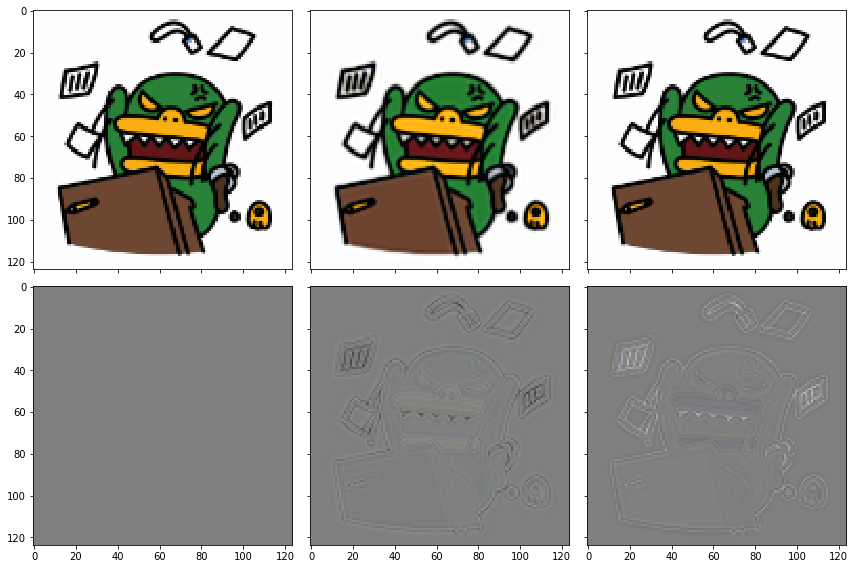

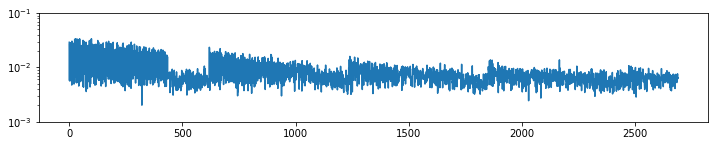

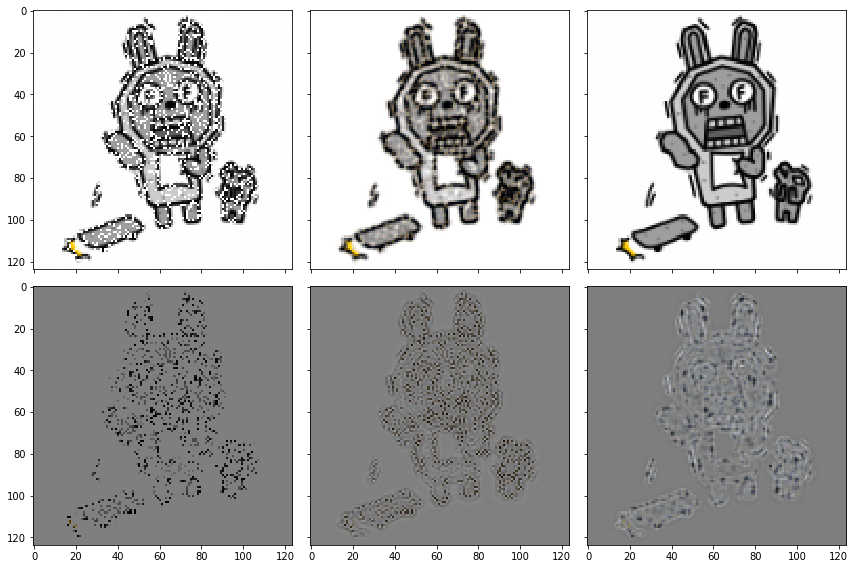

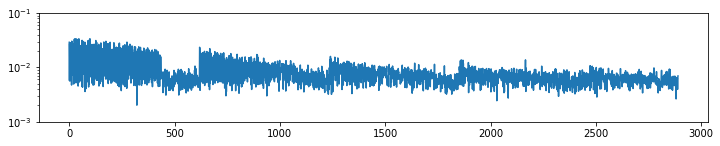

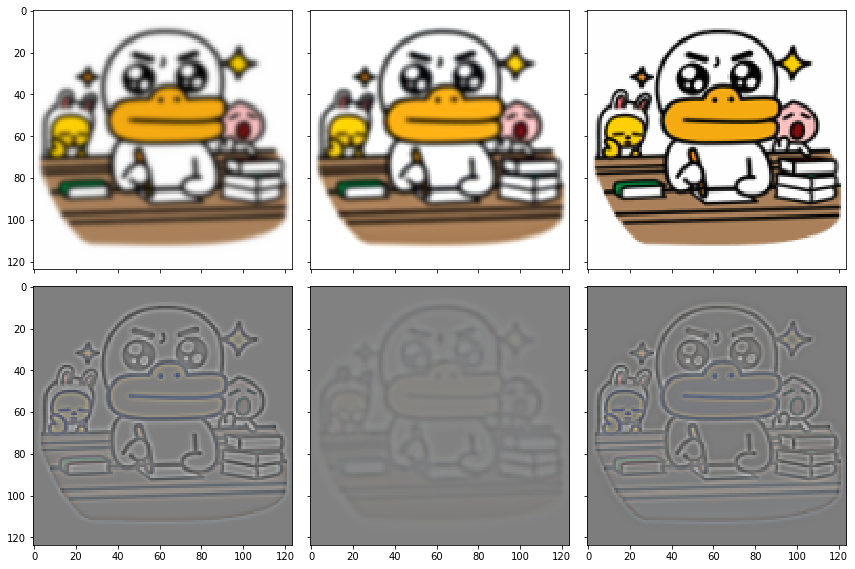

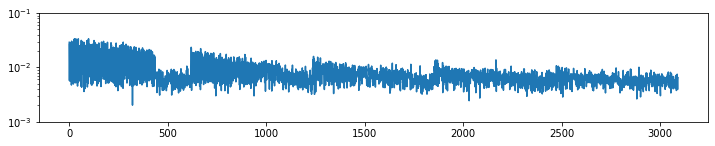

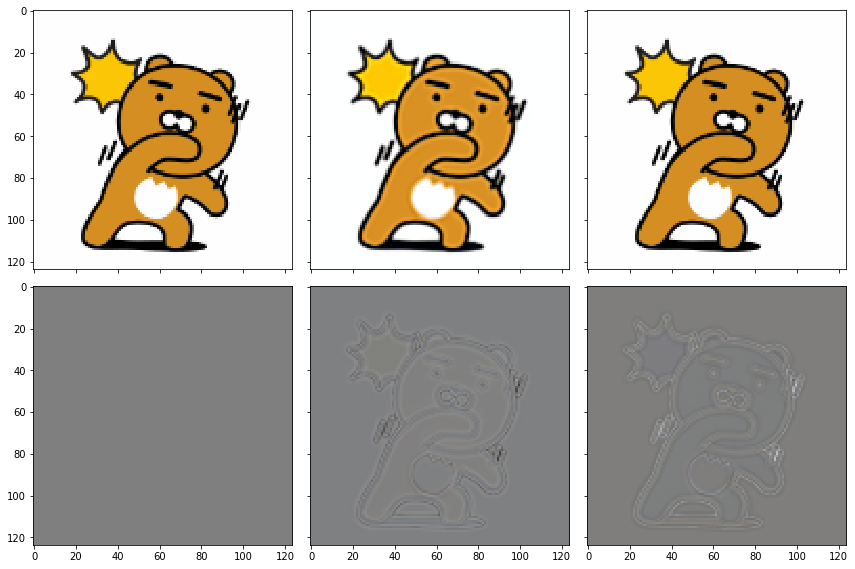

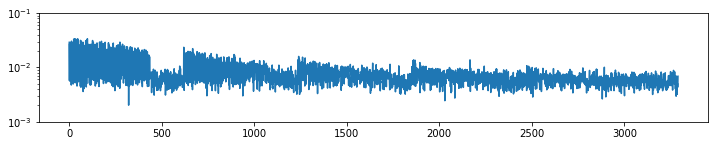

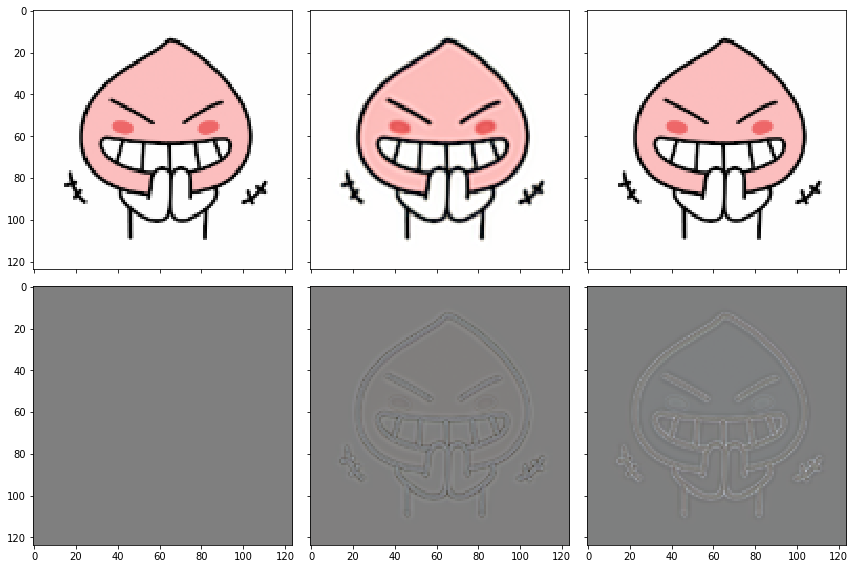

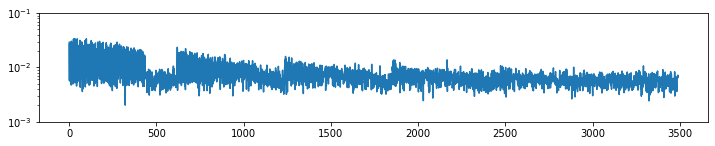

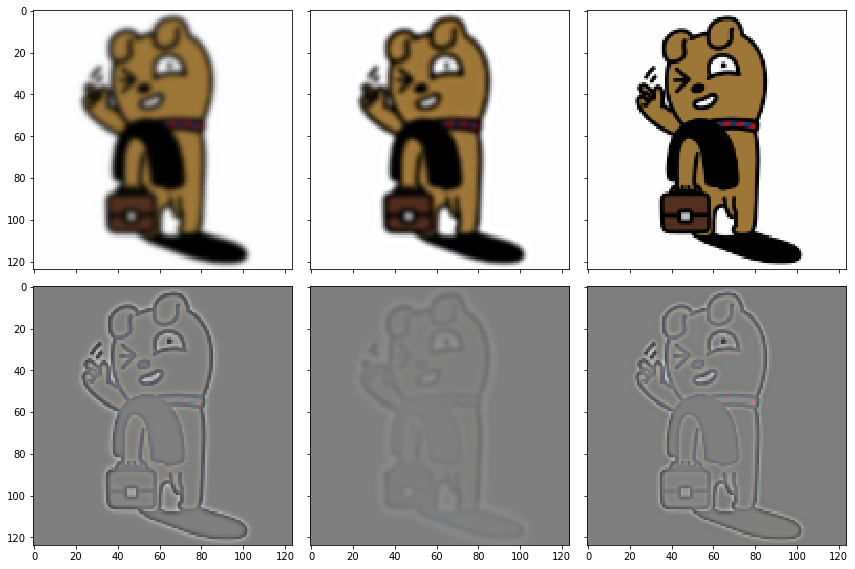

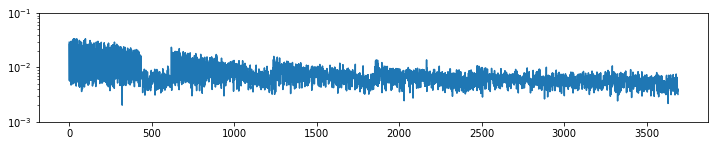

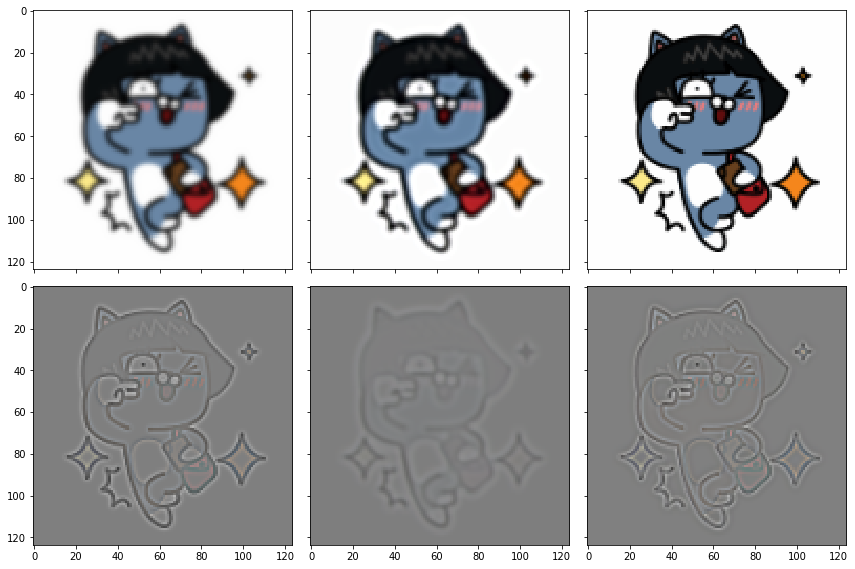

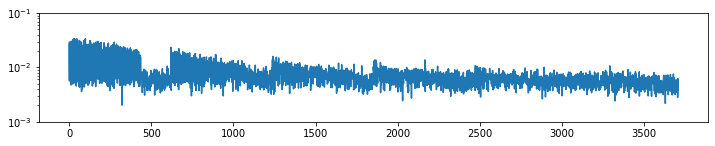

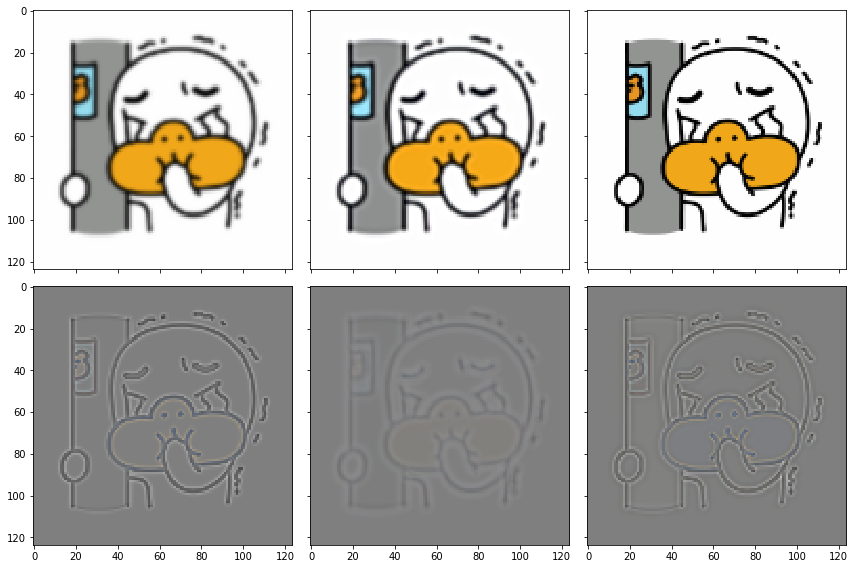

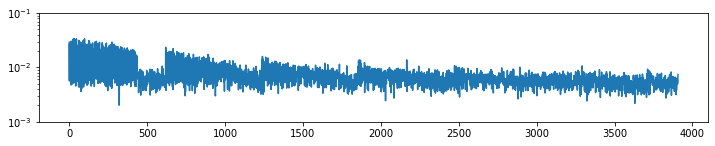

In [ ]:
for epoch in range(150):

    for i, batch in tqdm(enumerate(general_image_feeder.generator()), total=general_image_feeder.max_batch_num):

        batch_before, batch_after = batch

        optimizer.zero_grad()

        batch_pred = net(batch_before.to(device))
#         batch_pred = net(batch_pred) # 2 step prediction
#         batch_pred = net(batch_pred) # 3 step prediction
#         batch_pred = net(batch_pred) # 4 step prediction

        
        loss = criterion(batch_pred, batch_after.to(device))

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

#         if i == general_image_feeder.max_batch_num // 2:
        if i % 200 == 0:
            input_image = np.rollaxis(batch_before.numpy()[0], 0, 3)
            output_image = np.rollaxis(batch_pred.detach().cpu().numpy()[0], 0, 3)
            original_image = np.rollaxis(batch_after.numpy()[0], 0, 3)
            
            visualize_growth_result(input_image, output_image, original_image)

            plt.figure(figsize=(12, 2))
            plt.plot(loss_history)
            plt.yscale('log')
            plt.ylim([1e-3, 1e-1])
            plt.show()